# Project : 25-26: 4369 -- PROGRAMMING FOR DATA ANALYTICS


__Author    : Clyde Watts__  
__Lecturere : Andrew Beaty__  
__Date      : 2025-11-20__






## Introduction ##

This project will examine the data from a residintial solor system , and do some analysis.

The following data sets will be used

| Data Source | Description | File Type |
|:---|:---:|---:|
| Solis Inverter | This report contains various power KWh measurement for a day at an hour grain  | xls |
| Solis Inverter | This report contains various power KWh measurement for a month at an daily grain  | xls |
| Solis Inverter | This report contains various power KWh measurement for a year at an monthly grain  | xls |
| Bord Gas / ESB | This report contains daily export to grid | csv |
| MetEirn ? | Dublin Airport Weither  | csv / url |

__Imports__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
# xlrd is required for reading xls Excel files
import xlrd
import re
import sqlite3
import meteostat as mt

__Globals__

In [2]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


__Helper Functions__


[sqlite3 table schema](https://sqlite.org/faq.html#:~:text=If%20you%20are%20running%20the,including%20all%20tables%20and%20indices.)

In [3]:
def sqlite3_table_schema(conn, table_name):
    """
    Connects to the SQLite database at db_path and retrieves the schema of the specified table_name.
    Prints the schema in a formatted table.
    """
    csr = conn.cursor()
    csr.execute(f"PRAGMA table_info({table_name})")
    columns = csr.fetchall()

    print(f"--- Schema for '{table_name}' ---")
    print(f"{'ID':<5} {'Name':<15} {'Type':<10} {'NotNull':<10}")
    print("-" * 45)

    for col in columns:
        cid, name, dtype, notnull, dflt_value, pk = col
        print(f"{cid:<5} {name:<15} {dtype:<10} {notnull:<10}")


## Data Loads

__Database Setup__

In [4]:
print("Ensuring database directory exists...")
try:
    os.makedirs(f'{DATA_DIR}/db_sqlite/', exist_ok=True)
    print("Database directory ensured at:", f'{DATA_DIR}/db_sqlite/')
except Exception as e:
    print("Error creating database directory:", e)
print("Connecting to SQLite database...")
con = sqlite3.connect(SQL_DB_FILE)
sys_cur = con.cursor()
print("Connected to SQLite database at:", SQL_DB_FILE)

Ensuring database directory exists...
Database directory ensured at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//db_sqlite/
Connecting to SQLite database...
Connected to SQLite database at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//db_sqlite//big_project_db.sqlite3


### Solis Data Load

The solis data is manually extracted from the solas cloud client interface. This application requires a user logon and password

[Solis](https://www.soliscloud.com/)



### Load and Populate Solar Panel Data ###

The solar panel data is the yearly , monthly and daily inverter data from home solar system.  This data is retrieved from solas web site . The web site is a user logon website. The data had to be extracted manually , a period at a time. 

The data is placed in the directory ./big_project/data/raw_data/solar. 

[Home Solar System Website](https://www.soliscloud.com/station/stationDetails/generalSituation/1298491919449681542?glyun_vue2=%2F%23%2Fstation) 


[pandas read excel](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) 


[xlrd](https://pypi.org/project/xlrd/) 



In [5]:
# Load daily solar data
all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Daily*xls'):
    df_header = pd.read_excel(file, nrows=5, header=None)
    # get date from header
    the_date = None
    the_date_label = df_header.iat[0,0]
    # format of date is Plant_12-09-2024Chart
    result = re.search(r'(\d{2}-\d{2}-\d{4})', str(the_date_label))
    if result:
        date_str = result.group(1)
        the_date = datetime.datetime.strptime(date_str, '%d-%m-%Y').date()
    else:
        print("DQ Issue: Date not found in header")
        break
    # Get Total Yield from header oday Yield(kWh):29.500kWh
    total_yield_label = df_header.iat[3,0]
    result_yield = re.search(r'oday Yield\(kWh\):([\d\.]+)kWh', str(total_yield_label))
    if result_yield:
        total_yield = float(result_yield.group(1))
    # The file needs to be read from line 29
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    all_dfs.append(df)
# Combine all at once
df_raw_daily_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
print("Loaded solar data shape:", df_raw_daily_solar.shape)
# Convert to Time column to datetime.time 12:23:45 format
df_raw_daily_solar['Time'] = pd.to_datetime(df_raw_daily_solar['Time'], format='%H:%M:%S').dt.time
# Combine Date and Time into a single DateTime column
df_raw_daily_solar['DateTime'] = df_raw_daily_solar.apply(lambda row: datetime.datetime.combine(row['Date'], row['Time']), axis=1)


# Display first few rows
df_raw_daily_solar.head()


Loaded solar data shape: (118142, 11)


,Date,Number,Time,Working State,PV(W),Battery(W),Grid(W),Load(W),SOC(%),Total_Yield(kWh),Source_File,DateTime
0,2024-09-12,1,00:00:00,Online,1.0,-115.72,6.0,0.0,57.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:00:00
1,2024-09-12,2,00:05:00,Online,1.0,-210.00,0.0,211.0,57.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:05:00
2,2024-09-12,3,00:10:00,Online,1.0,-199.50,1.0,0.0,57.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:10:00
3,2024-09-12,4,00:15:00,Online,1.0,-199.50,0.0,0.0,56.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:15:00
4,2024-09-12,5,00:20:00,Online,1.0,-194.25,77.0,0.0,56.0,29.5,Daily+Power+Station+Chart_19-11-2025 (1).xls,2024-09-12 00:20:00


__Write to CSV and Database

[to_csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html)
[to_sql](https://pandas.pydata.org/pandas-docs/version/2.1.3/reference/api/pandas.DataFrame.to_sql.html)

In [6]:
print("Writing daily solar data to CSV...")
df_raw_daily_solar.to_csv(f'{DATA_DIR}/processed_data/df_raw_daily_solar.csv', index=False)
print(f"Wrote {len(df_raw_daily_solar)} rows to CSV.")
# Write to SQLite database
print("Writing daily solar data to SQLite database...")
row_count = df_raw_daily_solar.to_sql('daily_solar_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM daily_solar_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'daily_solar_data')


Writing daily solar data to CSV...
Wrote 118142 rows to CSV.
Writing daily solar data to SQLite database...
Wrote 118142 rows to SQLite database.
Verified 118142 rows in SQLite database.
--- Schema for 'daily_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     index           INTEGER    0         
1     Date            DATE       0         
2     Number          INTEGER    0         
3     Time            TIME       0         
4     Working State   TEXT       0         
5     PV(W)           REAL       0         
6     Battery(W)      REAL       0         
7     Grid(W)         REAL       0         
8     Load(W)         REAL       0         
9     SOC(%)          REAL       0         
10    Total_Yield(kWh) REAL       0         
11    Source_File     TEXT       0         
12    DateTime        TIMESTAMP  0         


__Validate Solar dataframe__

Check for the following
1. Shape
2. Columns
3. Any dates missing
4. Row count per day

In [7]:
print("Combined DataFrame shape:", df_raw_daily_solar.shape)
print("DataFrame info:")
df_raw_daily_solar.info()
print("Columns:", df_raw_daily_solar.columns.tolist())
df_dates = df_raw_daily_solar['Date'].unique()
print(f"Dates Min: {min(df_dates)}")
print(f"Dates Max: {max(df_dates)}")
print("Total unique dates in data:", len(df_dates))
print("Date Range In Days:", (max(df_dates) - min(df_dates)).days)
# Delete all rows after 2025-10-31
df_raw_daily_solar = df_raw_daily_solar[df_raw_daily_solar['Date'] <= datetime.date(2025, 10, 31)]
# Adjusted shape after filtering dates
print("DataFrame shape after filtering dates:", df_raw_daily_solar.shape)
# find missing dates
# create a complete date range
all_dates = pd.date_range(start=min(df_dates), end=max(df_dates))
# get the difference between all_dates and df_dates
missing_dates = all_dates.difference(df_dates)
print("Missing dates:", missing_dates)


Combined DataFrame shape: (118142, 12)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118142 entries, 0 to 118141
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              118142 non-null  object        
 1   Number            118142 non-null  int64         
 2   Time              118142 non-null  object        
 3   Working State     118142 non-null  object        
 4   PV(W)             118142 non-null  float64       
 5   Battery(W)        118142 non-null  float64       
 6   Grid(W)           118142 non-null  float64       
 7   Load(W)           118142 non-null  float64       
 8   SOC(%)            118142 non-null  float64       
 9   Total_Yield(kWh)  118142 non-null  float64       
 10  Source_File       118142 non-null  object        
 11  DateTime          118142 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memor

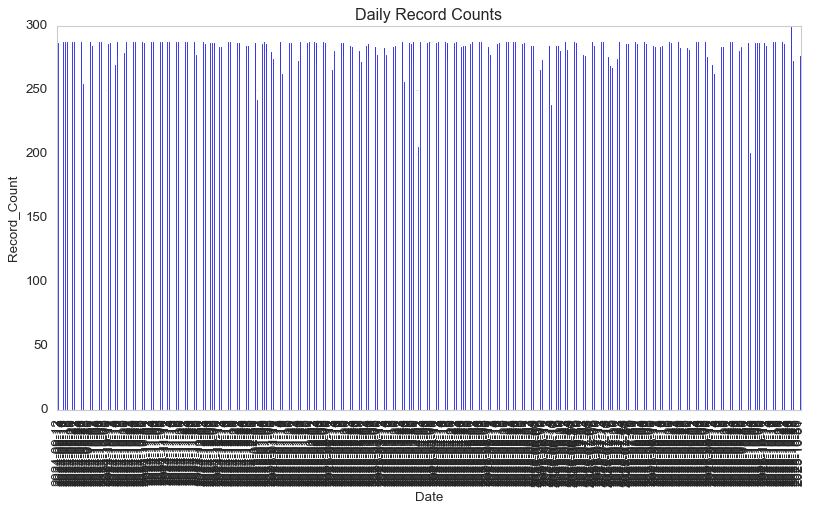

Outliers with MORE than 300 records:


,Date,Source_File


In [8]:
# Do a aggregation to daily level
df_date_counts = df_raw_daily_solar['Date'].value_counts().reset_index()
df_date_counts.columns = ['Date', 'Record_Count']
df_date_counts = df_date_counts.sort_values(by='Date')
# Plot the daily record counts
plt.figure(figsize=(12,6))
sns.barplot(data=df_date_counts, x='Date', y='Record_Count', color='blue')
plt.xticks(rotation=90)
plt.title('Daily Record Counts')
plt.show()
# print outliers where record count is less than 24
outliers = df_date_counts[df_date_counts['Record_Count'] > 300]
print("Outliers with MORE than 300 records:")
df_dups = df_raw_daily_solar[df_raw_daily_solar['Date'].isin(outliers['Date'])][['Date','Source_File']].drop_duplicates().sort_values(by='Date')
df_dups

#### Load Raw Monthly

In [9]:

all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Monthly*xls'):
    df_header = pd.read_excel(file, nrows=5, header=None)
    # get date from header
    the_date = None
    the_date_label = df_header.iat[0,0]
    # format of date is Plant_12-09-2024Chart
    result = re.search(r'(\d{2}-\d{4})', str(the_date_label))
    if result:
        date_str = result.group(1)
        the_date = datetime.datetime.strptime(date_str, '%m-%Y').date()
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df['Month'] = the_date
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    # Convert date column to date type format is dd-mm-yyyy
    #df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y').dt.date
    all_dfs.append(df)
# Combine all at once
df_raw_monthly_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
# Rename column Time to Date
df_raw_monthly_solar = df_raw_monthly_solar.rename(columns={'Time':'Date'})
# Convert Date column to date 
df_raw_monthly_solar['Date'] = pd.to_datetime(df_raw_monthly_solar['Date'], format='%d-%m-%Y').dt.date
# Set date as index
df_raw_monthly_solar.set_index('Date', inplace=True)


##### Write to CSV and Database

In [10]:
print("Writing monthly solar data to CSV...")
df_raw_monthly_solar.to_csv(f'{DATA_DIR}/processed_data/df_raw_monthly_solar.csv', index=False)
print(f"Wrote {len(df_raw_monthly_solar)} rows to CSV.")
# Write to SQLite database
print("Writing monthly solar data to SQLite database...")
row_count = df_raw_monthly_solar.to_sql('weekly_solar_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM weekly_solar_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'weekly_solar_data')

Writing monthly solar data to CSV...
Wrote 434 rows to CSV.
Writing monthly solar data to SQLite database...
Wrote 434 rows to SQLite database.
Verified 434 rows in SQLite database.
--- Schema for 'weekly_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     Date            DATE       0         
1     Number          INTEGER    0         
2     Yield(kWh)      REAL       0         
3     Earning(EUR)    REAL       0         
4     Full Load Hours(h) REAL       0         
5     Charged(kWh)    REAL       0         
6     Discharged(kWh) REAL       0         
7     Exported(kWh)   REAL       0         
8     Imported(kWh)   REAL       0         
9     Net Import(kWh) REAL       0         
10    Load(kWh)       REAL       0         
11    Month           DATE       0         
12    Source_File     TEXT       0         


__Validate Raw Monthly__

TODO

In [11]:

print("Combined Monthly DataFrame shape:", df_raw_monthly_solar.shape)  
print("DataFrame info:")
df_raw_monthly_solar.info()
print("Columns:", df_raw_monthly_solar.columns.tolist())
print("First 5 rows:")

# get min and max Date columns that will indicate range
min_date = df_raw_monthly_solar.index.min()
max_date = df_raw_monthly_solar.index.max()
no_dates = (max_date - min_date).days + 1
print("No dates in range:", no_dates)
# Date datatype check
print("Date column datatype:", df_raw_monthly_solar.index.dtype)
print(f"Date range: {min_date} to {max_date}")
#no_of_days = (max_date - min_date).days + 1
#print(f"Total number of days in range: {no_of_days}")
# Count unique dates
unique_dates = df_raw_monthly_solar.index.nunique()
print(f"Unique dates count: {unique_dates}")
if unique_dates == no_dates:
    print("No missing dates in the monthly solar data.")

Combined Monthly DataFrame shape: (434, 12)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 2024-10-01 to 2024-09-30
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Number              434 non-null    int64  
 1   Yield(kWh)          434 non-null    float64
 2   Earning(EUR)        434 non-null    float64
 3   Full Load Hours(h)  434 non-null    float64
 4   Charged(kWh)        434 non-null    float64
 5   Discharged(kWh)     434 non-null    float64
 6   Exported(kWh)       434 non-null    float64
 7   Imported(kWh)       434 non-null    float64
 8   Net Import(kWh)     434 non-null    float64
 9   Load(kWh)           434 non-null    float64
 10  Month               434 non-null    object 
 11  Source_File         434 non-null    object 
dtypes: float64(9), int64(1), object(2)
memory usage: 60.2+ KB
Columns: ['Number', 'Yield(kWh)', 'Earning(EUR)', 'Full Load Hours(h)', 'Ch

__Plot a few things to see how the data looks__

 Date                
 Yield(kWh)                 
 Full Load Hours(h)  
 Charged(kWh)        
 Discharged(kWh)     
 Exported(kWh)       
 Imported(kWh)       
 Net Import(kWh)     
 Load(kWh)           

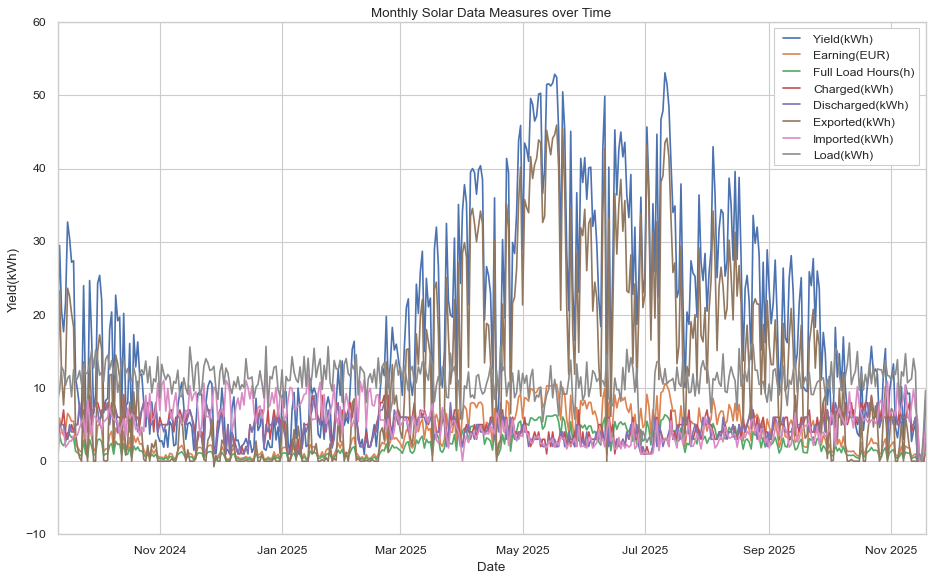

In [12]:
# plot date vs all the other measures in kWh on one plot
sns.set(style="whitegrid")
# Set title
plt.figure(figsize=(14, 8))
plt.title('Monthly Solar Data Measures over Time')
for column in df_raw_monthly_solar.columns:
    if column not in ['Date', 'Source_File', 'Month','Number','Earnings(EUR)','Net Import(kWh)']:
        sns.lineplot(data=df_raw_monthly_solar, x='Date', y=column, label=column)
plt.legend()
plt.show()

#### Load Yearly Raw Data

In [13]:

all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Annual*xls'):
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    all_dfs.append(df)
# Combine all at once
df_raw_annual_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
# Rename column Time to Date
df_raw_annual_solar = df_raw_annual_solar.rename(columns={'Time':'Month'})
# Create Date column from Month
df_raw_annual_solar['Date'] = '01-' + df_raw_annual_solar['Month']
# Convert Date column to datetime
df_raw_annual_solar['Date'] = pd.to_datetime(df_raw_annual_solar['Date'], format='%d-%m-%Y').dt.date

    

__Validate Yearly__

In [14]:
print("Combined Annual DataFrame shape:", df_raw_annual_solar.shape)  
print("DataFrame info:")
df_raw_annual_solar.info()
print("Columns:", df_raw_annual_solar.columns.tolist())
df_raw_annual_solar.head(16)

Combined Annual DataFrame shape: (15, 14)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                15 non-null     object 
 1   Number              15 non-null     int64  
 2   Month               15 non-null     object 
 3   Yield(kWh)          15 non-null     float64
 4   Earning(EUR)        15 non-null     float64
 5   Full Load Hours(h)  15 non-null     float64
 6   Charged(kWh)        15 non-null     float64
 7   Discharged(kWh)     15 non-null     float64
 8   Exported(kWh)       15 non-null     float64
 9   Imported(kWh)       15 non-null     float64
 10  Net Import(kWh)     15 non-null     float64
 11  Load(kWh)           15 non-null     float64
 12  Total_Yield(kWh)    15 non-null     float64
 13  Source_File         15 non-null     object 
dtypes: float64(10), int64(1), object(3)
memory usage: 

,Date,Number,Month,Yield(kWh),Earning(EUR),Full Load Hours(h),Charged(kWh),Discharged(kWh),Exported(kWh),Imported(kWh),Net Import(kWh),Load(kWh),Total_Yield(kWh),Source_File
0,2025-01-01,1,01-2025,210.0,42.00,25.12,144.0,133.0,60.48,234.24,173.76,372.76,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
1,2025-02-01,2,02-2025,237.0,47.40,28.35,150.0,140.0,91.56,195.48,103.92,330.92,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
2,2025-03-01,3,03-2025,602.0,120.40,72.01,175.0,161.0,388.20,156.48,-231.72,356.28,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
3,2025-04-01,4,04-2025,896.0,179.20,107.18,139.0,131.0,687.36,116.04,-571.32,316.68,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
4,2025-05-01,5,05-2025,1280.0,256.00,153.11,101.0,92.0,1053.60,86.76,-966.84,304.16,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
5,2025-06-01,6,06-2025,994.5,198.90,118.96,100.0,93.0,755.64,78.60,-677.04,310.46,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
6,2025-07-01,7,07-2025,981.7,196.34,117.43,116.0,112.0,752.52,89.88,-662.64,315.06,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
7,2025-08-01,8,08-2025,878.0,175.60,105.02,144.0,132.0,624.60,113.40,-511.20,354.80,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
8,2025-09-01,9,09-2025,571.5,114.30,68.36,157.0,150.0,355.08,112.92,-242.16,322.34,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
9,2025-10-01,10,10-2025,292.1,58.42,34.94,203.0,192.0,107.52,197.76,90.24,371.34,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls


__Plot Data__

Plot to see what it looks like. Should see a bell like curve because of the seasonality



NameError: name 'mdates' is not defined

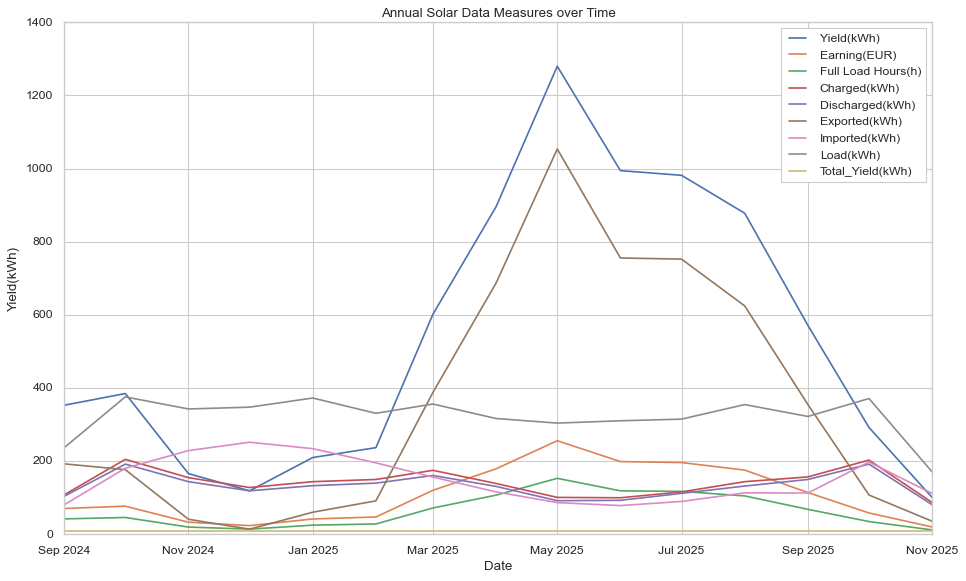

In [15]:
# plot date vs all the other measures in kWh on one plot
sns.set(style="whitegrid")
# Set title
plt.figure(figsize=(14, 8))
plt.title('Annual Solar Data Measures over Time')
for column in df_raw_annual_solar.columns:
    if column not in ['Date', 'Source_File', 'Month','Number','Earnings(EUR)','Net Import(kWh)']:
        sns.lineplot(data=df_raw_annual_solar, x='Date', y=column, label=column)
ax = plt.gca() # Get current axis

# 1. Set the Locator: Tell matplotlib to put a tick at every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# 2. Set the Formatter: Tell matplotlib how to write the text (e.g., Jan-2023)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# 3. Rotate ticks
plt.tick_params(axis='x', rotation=90)
plt.legend()
plt.show()

##### Write to CSV and Database

In [16]:
print("Writing yearly solar data to CSV...")
df_raw_annual_solar.to_csv(f'{DATA_DIR}/processed_data/df_raw_yearly_solar.csv', index=False)
print(f"Wrote {len(df_raw_annual_solar)} rows to CSV.")
# Write to SQLite database
print("Writing yearly solar data to SQLite database...")
row_count = df_raw_annual_solar.to_sql('monthly_solar_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM monthly_solar_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'monthly_solar_data')

Writing yearly solar data to CSV...
Wrote 15 rows to CSV.
Writing yearly solar data to SQLite database...
Wrote 15 rows to SQLite database.
Verified 15 rows in SQLite database.
--- Schema for 'monthly_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     index           INTEGER    0         
1     Date            DATE       0         
2     Number          INTEGER    0         
3     Month           TEXT       0         
4     Yield(kWh)      REAL       0         
5     Earning(EUR)    REAL       0         
6     Full Load Hours(h) REAL       0         
7     Charged(kWh)    REAL       0         
8     Discharged(kWh) REAL       0         
9     Exported(kWh)   REAL       0         
10    Imported(kWh)   REAL       0         
11    Net Import(kWh) REAL       0         
12    Load(kWh)       REAL       0         
13    Total_Yield(kWh) REAL       0         
14    Source_File     TEXT       0         


In [17]:
# List all tables in the database
sys_cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = sys_cur.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])

Tables in the database:
daily_esb_microgen_data
daily_dublin_weather_data
hourly_weather_data
daily_solar_data
weekly_solar_data
monthly_solar_data


### Load ESB Microgeneration Data

In [18]:
# load into pandas dataframe csv file
df_raw_esb_microgen = pd.read_csv(f'{RAW_DATA_DIR}/esb/BGE_Export_HDF_18_11_2025.csv')
# change Date column to date
df_raw_esb_microgen['Date'] = pd.to_datetime(df_raw_esb_microgen['Date']).dt.date 
# change Date to index
df_raw_esb_microgen.set_index('Date', inplace=True)

In [19]:
print("ESB Microgen DataFrame shape:", df_raw_esb_microgen.shape)
print("DataFrame info:")
df_raw_esb_microgen.info()
print("Columns:", df_raw_esb_microgen.columns.tolist())
print("First 5 rows:")
print(df_raw_esb_microgen.head())


ESB Microgen DataFrame shape: (435, 3)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 2024-09-05 to 2025-11-13
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MPRN                 435 non-null    int64  
 1   Export Volume (kWh)  435 non-null    float64
 2   Export Type          435 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 13.6+ KB
Columns: ['MPRN', 'Export Volume (kWh)', 'Export Type']
First 5 rows:
                  MPRN  Export Volume (kWh) Export Type
Date                                                   
2024-09-05  9999999999                  0.0     Metered
2024-09-06  9999999999                  0.0     Metered
2024-09-07  9999999999                  0.0     Metered
2024-09-08  9999999999                  0.0     Metered
2024-09-09  9999999999                  0.0     Metered


#### Write to CSV and Database

In [20]:
print("Writing daily ESB microgen data to CSV...")
df_raw_esb_microgen.to_csv(f'{DATA_DIR}/processed_data/df_raw_daily_esb_microgen.csv', index=False)
print(f"Wrote {len(df_raw_esb_microgen)} rows to CSV.")
# Write to SQLite database
print("Writing daily ESB microgen data to SQLite database...")
row_count = df_raw_esb_microgen.to_sql('daily_esb_microgen_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM daily_esb_microgen_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'daily_esb_microgen_data')

Writing daily ESB microgen data to CSV...
Wrote 435 rows to CSV.
Writing daily ESB microgen data to SQLite database...
Wrote 435 rows to SQLite database.
Verified 435 rows in SQLite database.
--- Schema for 'daily_esb_microgen_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     Date            DATE       0         
1     MPRN            INTEGER    0         
2     Export Volume (kWh) REAL       0         
3     Export Type     TEXT       0         


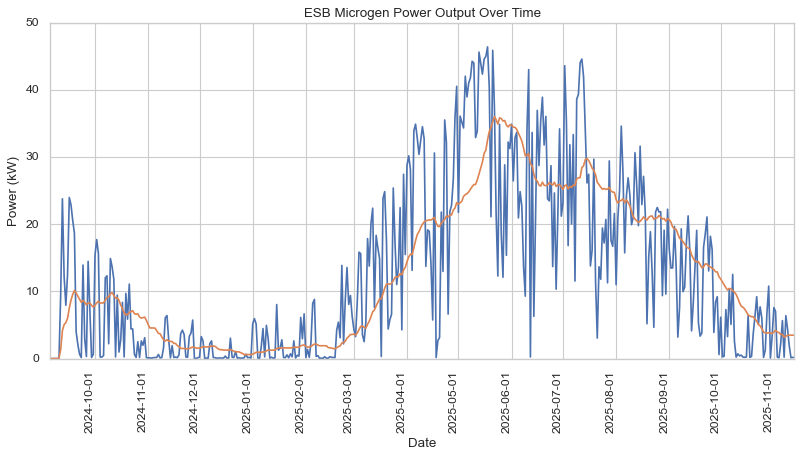

In [21]:

# Plot esb microgen data
plt.figure(figsize=(12,6))
ss = df_raw_esb_microgen['Export Volume (kWh)']
ss.plot()
# plot a smooth line
ss.rolling(window=30,min_periods=1).mean().plot()
plt.title('ESB Microgen Power Output Over Time')
plt.xlabel('Date')
# set x axis major ticks to monthly at 90 degrees
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate(rotation=90)
plt.ylabel('Power (kW)')
plt.grid(True)
plt.show()

__Analysis__

The question is , does ESB microgeneration kWH per day compare with the amount of power exported to the grid. The data from solar system (df_raw_monthly_solar) Column Exported(kWh)  and ESB microgeneration(df_raw_esb_microgen) column (Export Volume (kWh)) need to be joined on the same date grain. That is date.

In [22]:

df_esb_solar_merged = pd.merge(left=df_raw_esb_microgen['Export Volume (kWh)'].copy().reset_index('Date'),
         right=df_raw_monthly_solar['Exported(kWh)'].copy().reset_index('Date'),how='inner', on='Date')
# subtact the two columns to see difference
df_esb_solar_merged['Difference(kWh)'] = df_esb_solar_merged['Exported(kWh)'] - df_esb_solar_merged['Export Volume (kWh)']

__Plot Results__

This will compare the results of data measured by ESB and Solar System Inverter. This is to see if there are any obvious differences between the measurements. There is expected to be a slight difference because the two devices are different , and they are measureing at different point. At a visual difference there is no real measurable difference except for 1 day , which may be related to a power outage . 

__Observation__

The graph show that there is no material difference , if the outlier is removed that it shows a over reporting for ESB , or under for solar . We cannot determine which one is correct , rather we know either , or both are slighly incorrect.

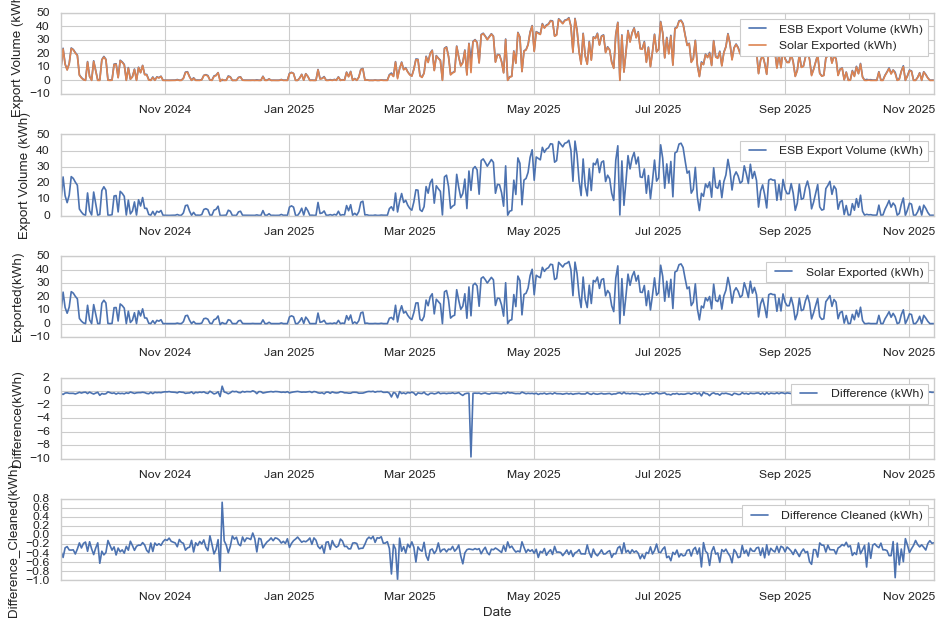

In [23]:
fig, ax = plt.subplots(5, 1, figsize=(12, 8))

# Combined plot first
sns.lineplot(data=df_esb_solar_merged, x='Date', y='Export Volume (kWh)', label='ESB Export Volume (kWh)', ax=ax[0])
sns.lineplot(data=df_esb_solar_merged, x='Date', y='Exported(kWh)', label='Solar Exported (kWh)', ax=ax[0])
ax[0].set_xlabel('')

# Plot each separately
sns.lineplot(data=df_esb_solar_merged, x='Date', y='Export Volume (kWh)', label='ESB Export Volume (kWh)', ax=ax[1])
ax[1].set_xlabel('')

sns.lineplot(data=df_esb_solar_merged, x='Date', y='Exported(kWh)', label='Solar Exported (kWh)', ax=ax[2])
ax[2].set_xlabel('')

sns.lineplot(data=df_esb_solar_merged, x='Date', y='Difference(kWh)', label='Difference (kWh)', ax=ax[3])
ax[3].set_xlabel('')

# Replace outlier values in Difference(kWh) with NaN for better visualization
# using a lambda function to set values greater than abs(5) to NaN
# a lamba is an anonymous function in Python
df_esb_solar_merged['Difference_Cleaned(kWh)'] = df_esb_solar_merged['Difference(kWh)'].apply(lambda x: x if abs(x) < 5 else np.nan)
sns.lineplot(data=df_esb_solar_merged, x='Date', y='Difference_Cleaned(kWh)', label='Difference Cleaned (kWh)', ax=ax[4])

plt.tight_layout()
plt.show()

__Method Comparison Study__

I used the following prompt on gemini 3.0 Thinking

I am doing a project on my solar panels at home , i have two measures of the same thing. Exported KWh but from different sources , what statistical techinques can i use to analise the difference

The prompt gave me a number of options

1. The Gold Standard: Bland-Altman Plot
2. Hypothesis Testing: Paired t-Test
3. Error Metrics: MAE and RMSE



__Bland-Altman Plot__

This is the primary visual test used in science and engineering to compare two measurement techniques.

What it does: It plots the Difference between the two sources (Y-axis) against the Average of the two sources (X-axis).

Why use it: It instantly reveals if the error gets worse as generation gets higher (proportional bias) or if one meter always reads higher by a fixed amount (systematic bias).

Examing the results

- there is one outlier
- systemic bias - there is a slight bias above the meaning that one of the devices is overreading, or alternatively one of the readers is slightly higher than the other , we do not know which one is the truth
- consistency - there is strong consistency because the reading consistent along the limits of agreement

[Wiki Band Altman Plot](https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot)

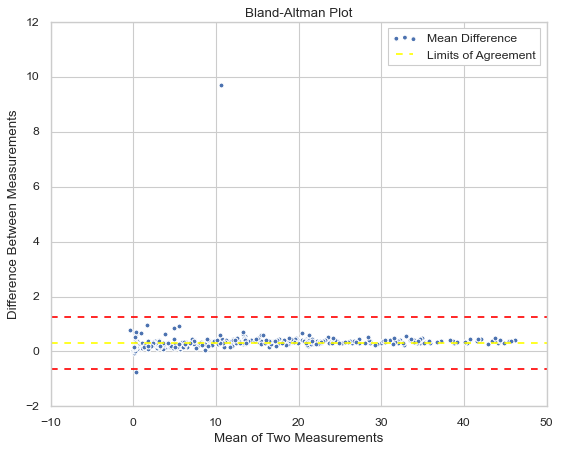

Outliers where difference is greater than 5 kWh:


,Date,Export Volume (kWh),Exported(kWh),Difference(kWh),Difference_Cleaned(kWh)
201,2025-03-31,15.4915,5.76,-9.7315,NaN


In [ ]:
# View Bland-Altman Plot
# asarray converts pandas series to numpy array
data1 = np.asarray(df_esb_solar_merged['Export Volume (kWh)'])
data2 = np.asarray(df_esb_solar_merged['Exported(kWh)'])
# calculate the mean between the two measurements and the difference
mean = np.mean([data1, data2], axis=0)
diff = data1 - data2
plt.scatter(mean, diff)
plt.axhline(np.mean(diff), color='orange', linestyle='--')
plt.axhline(np.mean(diff) + 1.96*np.std(diff), color='red', linestyle='--')
plt.axhline(np.mean(diff) - 1.96*np.std(diff), color='red', linestyle='--')
plt.xlabel('Mean of Two Measurements')
plt.ylabel('Difference Between Measurements')
plt.title('Bland-Altman Plot')
# The yellow line represents the mean difference
# The red lines represent the limits of agreement (mean difference ± 1.96 standard deviations)
plt.legend(['Mean Difference', 'Limits of Agreement'])
plt.show()
# print out the outlier

print("Outliers where difference is greater than 5 kWh:")
outliers = df_esb_solar_merged[abs(df_esb_solar_merged['Difference(kWh)']) > 5]
outliers

__Hypothesis Test ( Paired t-test )__

Paired t-test: Use this if your differences are normally distributed (bell curve).

In [25]:
from scipy import stats
# remove the outliers for the t-test
df_esb_solar_merged_no_outliers = df_esb_solar_merged[abs(df_esb_solar_merged['Difference(kWh)']) <= 5]
data1 = np.asarray(df_esb_solar_merged_no_outliers['Export Volume (kWh)'])
data2 = np.asarray(df_esb_solar_merged_no_outliers['Exported(kWh)'])
# perform paired t-test
t_stat, p_value = stats.ttest_rel(data1, data2)
print(f"\n--- Statistical Test (Paired t-test) ---")
print(f"P-value: {p_value:.5f}")
if p_value < 0.05:
    print("Result: Statistically Significant Difference (The sources are NOT the same)")
else:
    print("Result: No significant difference found")


--- Statistical Test (Paired t-test) ---
P-value: 0.00000
Result: Statistically Significant Difference (The sources are NOT the same)


You can know if the paired t-test is valid by checking three specific assumptions.

For solar data, the most critical one is Normality of the Differences. Many people mistakenly think the solar generation itself needs to be a Bell curve (which it never is—it's zero at night and high in summer). This is wrong. Only the difference between your Inverter and Utility meter needs to look like a Bell curve.

The 3 Assumptions Checklist
Continuous Data: Verified. (Kilowatt-hours are continuous numbers).

Independence of Pairs: Verified. (The error on Monday doesn't "cause" the error on Tuesday; each day is a separate event).

Normality of Differences: Must be tested. The Inverter - Utility values should form a Bell curve (Normal Distribution).

How to Interpret the Results
If the Histogram is a Bell Curve (and p-value > 0.05): Your differences are random "noise." The Paired t-test is the correct tool.

If the Histogram is skewed or flat (and p-value < 0.05): Your differences are not random. This often happens in solar if the inverter has a "cutoff" issue or if that outlier you found earlier is skewing the data.

Solution: Use the Wilcoxon Signed-Rank Test. It does the same job as the t-test but doesn't care about Bell curves.

Python code: stats.wilcoxon(df['Inverter'], df['Meter'])

Important Note on Your Outlier

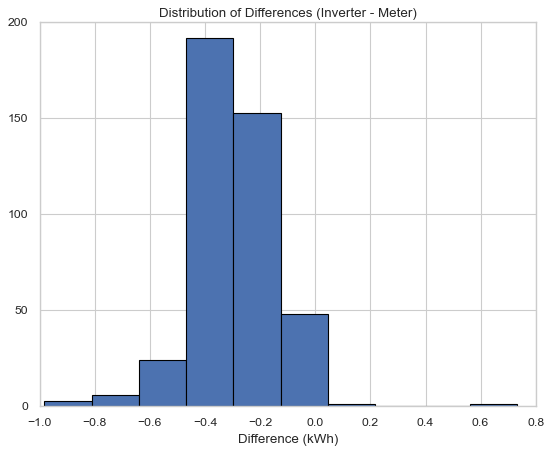

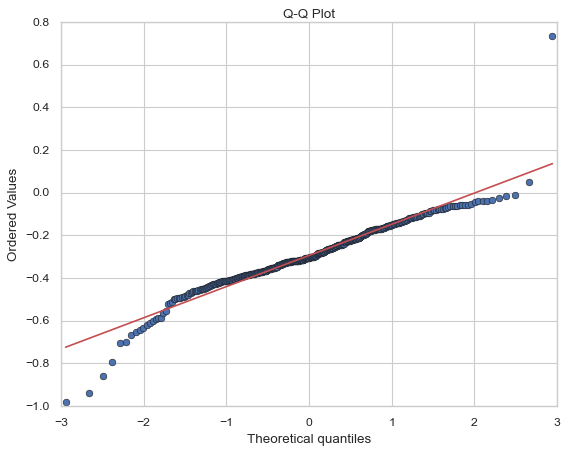

Shapiro-Wilk P-Value: 0.00000
FAILED: Data is NOT Normal. Use 'Wilcoxon Signed-Rank Test' instead.


In [26]:
import matplotlib.pyplot as plt
import scipy.stats as stats
df = df_esb_solar_merged_no_outliers.copy()
df = df.rename(columns={'Export Volume (kWh)': 'Meter', 'Exported(kWh)': 'Inverter'})
# 1. Calculate the Difference
df['Diff'] = df['Inverter'] - df['Meter']

# 2. Visual Check: Histogram
# It should look like a Bell Curve centered roughly around 0 (or your bias)
plt.hist(df['Diff'], bins=10, edgecolor='black')
plt.title('Distribution of Differences (Inverter - Meter)')
plt.xlabel('Difference (kWh)')
plt.show()

# 3. Visual Check: Q-Q Plot
# The dots should roughly follow the red line
stats.probplot(df['Diff'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

# 4. Mathematical Check: Shapiro-Wilk Test
# This gives you a p-value.
stat, p_value = stats.shapiro(df['Diff'])

print(f"Shapiro-Wilk P-Value: {p_value:.5f}")

if p_value > 0.05:
    print("PASSED: Data is Normal. You CAN use the Paired t-test.")
else:
    print("FAILED: Data is NOT Normal. Use 'Wilcoxon Signed-Rank Test' instead.")

In [27]:
stats.wilcoxon(df['Inverter'], df['Meter'])

WilcoxonResult(statistic=np.float64(433.0), pvalue=np.float64(1.4993676371925262e-70))

In [28]:
# 2. Run the Wilcoxon Signed-Rank Test
# We use 'two-sided' to check if they are simply different (not specifically higher/lower)
statistic, p_value = stats.wilcoxon(df['Inverter'], df['Meter'], alternative='two-sided')

print("--- Wilcoxon Signed-Rank Test Results ---")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value:.5f}")

# 3. Interpretation Logic
print("\n--- Conclusion ---")
if p_value < 0.05:
    print("Result: SIGNIFICANT DIFFERENCE")
    print("There is a statistically significant difference between the Inverter and Utility meter.")
    
    # Check who is higher by looking at the median difference
    median_diff = (df['Inverter'] - df['Meter']).median()
    if median_diff > 0:
        print(f"Direction: The Inverter reads higher (Median diff: {median_diff:.3f} kWh)")
    else:
        print(f"Direction: The Utility Meter reads higher (Median diff: {median_diff:.3f} kWh)")

else:
    print("Result: NO SIGNIFICANT DIFFERENCE")
    print("The differences are likely just random noise. The devices measure effectively the same.")

--- Wilcoxon Signed-Rank Test Results ---
Statistic: 433.0
P-value: 0.00000

--- Conclusion ---
Result: SIGNIFICANT DIFFERENCE
There is a statistically significant difference between the Inverter and Utility meter.
Direction: The Utility Meter reads higher (Median diff: -0.305 kWh)


Plot of wilcox 

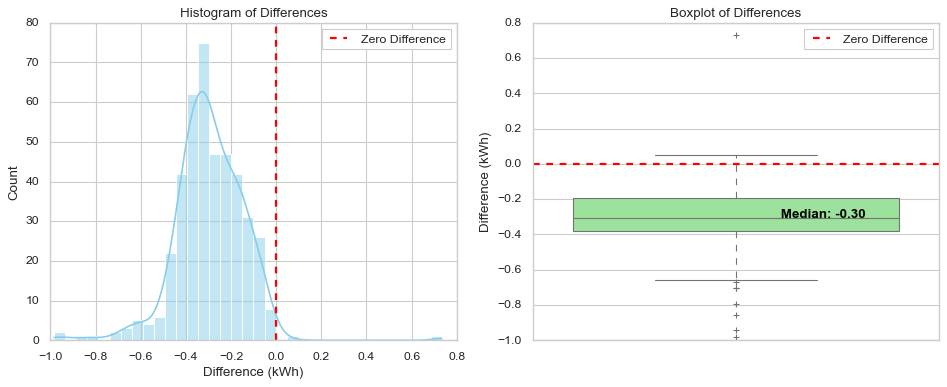

In [29]:
# 2. Create the Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot A: Histogram (Distribution Check) ---
sns.histplot(df['Diff'], kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Difference')
axes[0].set_title('Histogram of Differences')
axes[0].set_xlabel('Difference (kWh)')
axes[0].legend()

# --- Plot B: Boxplot (The Wilcoxon Companion) ---
sns.boxplot(y=df['Diff'], ax=axes[1], color='lightgreen')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Difference')
axes[1].set_title('Boxplot of Differences')
axes[1].set_ylabel('Difference (kWh)')
axes[1].legend()

# Add a note about the median
median_val = df['Diff'].median()
axes[1].text(0.1, median_val, f' Median: {median_val:.2f}', 
             color='black', weight='bold', ha='left')

plt.tight_layout()
plt.show()

Detected Systematic Bias: -0.3047 kWh


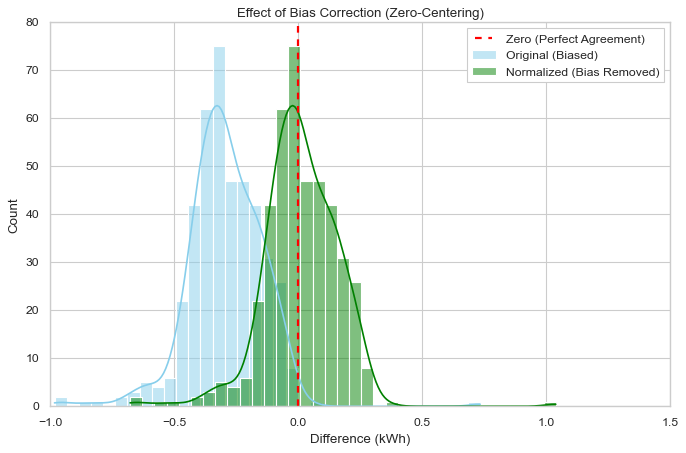

New Median after correction: 0.0000 kWh (Should be 0.0)


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your dataframe and 'Diff' is the column plotted above
# 1. Calculate the Systematic Bias (using Median to be robust against outliers)
bias = df['Diff'].median()

print(f"Detected Systematic Bias: {bias:.4f} kWh")

# 2. Create the "Normalized" Data (Centralized on Zero)
# We subtract the bias from the difference
df['Diff_Normalized'] = df['Diff'] - bias

# --- PLOTTING ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Original (with Bias)
sns.histplot(df['Diff'], color='skyblue', alpha=0.5, label='Original (Biased)', kde=True)

# Plot Normalized (Centered on Zero)
sns.histplot(df['Diff_Normalized'], color='green', alpha=0.5, label='Normalized (Bias Removed)', kde=True)

# Add the Zero line
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero (Perfect Agreement)')

plt.title('Effect of Bias Correction (Zero-Centering)')
plt.xlabel('Difference (kWh)')
plt.legend()
plt.show()

# --- CHECK NEW METRICS ---
new_median = df['Diff_Normalized'].median()
print(f"New Median after correction: {new_median:.4f} kWh (Should be 0.0)")

In [31]:
# --- METHOD A: Cohen's d (For Paired t-test) ---
# Mean of difference / Std Dev of difference
cohens_d = np.mean(diff) / np.std(diff, ddof=1)

# --- METHOD B: Rank-Biserial Correlation (For Wilcoxon) ---
# We perform the Wilcoxon test to get the rank sums
# exact=True is preferred for small datasets (<25), False for larger
w_stat, _ = stats.wilcoxon(df['Inverter'], df['Meter'])

# Calculate total ranks (Formula: N * (N + 1) / 2)
n = len(diff)
total_rank_sum = n * (n + 1) / 2

# In scipy, w_stat is the minimum of the two sums (positive or negative)
# So we can reverse-engineer the correlation (r)
# r = 1 - (2 * w_stat) / total_rank_sum
r_biserial = 1 - (2 * w_stat) / total_rank_sum

print("--- Effect Size Results ---")

print(f"\n1. Cohen's d (If using t-test): {cohens_d:.3f}")
# Interpretation Logic for Cohen's d
if abs(cohens_d) < 0.2: print("   -> Negligible Effect")
elif abs(cohens_d) < 0.5: print("   -> Small Effect")
elif abs(cohens_d) < 0.8: print("   -> Medium Effect")
else: print("   -> Large Effect (The difference is very noticeable)")

print(f"\n2. Rank-Biserial r (If using Wilcoxon): {r_biserial:.3f}")
# Interpretation Logic for r
if abs(r_biserial) < 0.1: print("   -> Negligible Effect")
elif abs(r_biserial) < 0.3: print("   -> Small Effect")
elif abs(r_biserial) < 0.5: print("   -> Medium Effect")
else: print("   -> Large Effect")

print("\n------------------------------------------------")
print("Note: If the number is POSITIVE, the Inverter is higher.")
print("Note: If the number is NEGATIVE, the Meter is higher.")

--- Effect Size Results ---

1. Cohen's d (If using t-test): 0.659
   -> Medium Effect

2. Rank-Biserial r (If using Wilcoxon): 0.991
   -> Large Effect

------------------------------------------------
Note: If the number is POSITIVE, the Inverter is higher.
Note: If the number is NEGATIVE, the Meter is higher.


### Load  Weather Data

The first iteration the local weather was downloaded from Data.gov.ie - Dublin Airport Hourly Data. After some investigation , a more general source was found Meteostat was found. This gives a similar data set to data.gov.ie with the advantage that it downloads directly into a dataframe , and it has a local cache.

[Meteostat](https://meteostat.net/en/)  
[Meteostat Columns](https://dev.meteostat.net/formats.html#time-format)  
[Dublin Airport Hourly Data](https://data.gov.ie/dataset/dublin-airport-hourly-data)  
[Dublin Airport Weather](https://cli.fusio.net/cli/climate_data/webdata/hly532.csv)  



In [101]:
# Load hourly weather data for Dublin
#df_weather_dublin = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/hly532.csv', skiprows=23)
mt.Stations.cache_dir = METEOSTAT_CACHE_DIR
stations = mt.Stations()
# Get the stations near the specified latitude and longitude
stations = stations.nearby(LATITUDE, LONGITUDE)
# Get the first station from the list , which is usually the closest one
df_station = stations.fetch(1)
# Reset index to access station ID
df_station.reset_index(inplace=True)
print(f"Station ID: {df_station['id'][0]}")
print(f"Station Name: {df_station['name'][0]}")
print(f"Station Distance: {df_station['distance'][0]:.2f} m")
# Get local station ID
station_id = df_station['id'][0]
# Get hourly data
data = mt.Hourly(station_id, WEATHER_START_DATE, WEATHER_END_DATE,timezone='Europe/Dublin')
# fetch the data
weather_df = data.fetch()
# set index to default integer index
weather_df.reset_index(inplace=True)
# find all missing values in the dataframe
missing_values = weather_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0].to_string())
# fix missing values by forward filling and then backward filling
weather_df.ffill(inplace=True)
weather_df.bfill(inplace=True)
# find all missing values in the dataframe
missing_values = weather_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0].to_string())
# explode the dataframe time to 10 minute intervals
weather_df.set_index('time', inplace=True)
weather_df = weather_df.resample('10T').interpolate(method='linear')
weather_df.reset_index(inplace=True)
# we are only interested in time, temperature, humidity, and solar radiation
weather_df = weather_df[['time', 'temp', 'rhum', 'tsun','coco']]
# rename columns for clarity
weather_df.rename(columns={'time': 'DateTime', 'temp': 'Temperature(C)', 'rhum': 'Humidity(%)', 'tsun': 'Solar Radiation(W/m^2)','coco': 'Condition Code'}, inplace=True)
# Change DateTime - Drop timezone info to Europe/Dublin need that later for merging with other data
weather_df['DateTime'] = weather_df['DateTime'].dt.tz_convert('Europe/Dublin').dt.tz_localize(None)
print("Weather DataFrame shape:", weather_df.shape)
print("DataFrame info:")
weather_df.info()
print("Columns:", weather_df.columns.tolist())
print("First 5 rows:")
print(weather_df.head())

Station ID: 03969
Station Name: Dublin Airport
Station Distance: 29619.04 m
Missing values in each column:
prcp      483
snow    16011
Missing values in each column:
Series([], )
Weather DataFrame shape: (100117, 5)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100117 entries, 0 to 100116
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DateTime                100117 non-null  datetime64[ns]
 1   Temperature(C)          100117 non-null  Float64       
 2   Humidity(%)             100117 non-null  Float64       
 3   Solar Radiation(W/m^2)  100117 non-null  Float64       
 4   Condition Code          100117 non-null  Float64       
dtypes: Float64(4), datetime64[ns](1)
memory usage: 4.2 MB
Columns: ['DateTime', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code']
First 5 rows:
             DateTime  Temperature(C)  Humidity(%)  Solar R

#### Write to CSV and Database

In [102]:
print("Writing daily Dublin weather data to CSV...")
weather_df.to_csv(f'{DATA_DIR}/processed_data/df_weather.csv', index=False)
print(f"Wrote {len(weather_df)} rows to CSV.")
# Write to SQLite database
print("Writing daily Dublin weather data to SQLite database...")
row_count = weather_df.to_sql('hourly_weather_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM hourly_weather_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'hourly_weather_data')

Writing daily Dublin weather data to CSV...
Wrote 100117 rows to CSV.
Writing daily Dublin weather data to SQLite database...
Wrote 100117 rows to SQLite database.
Verified 100117 rows in SQLite database.
--- Schema for 'hourly_weather_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     index           INTEGER    0         
1     DateTime        TIMESTAMP  0         
2     Temperature(C)  REAL       0         
3     Humidity(%)     REAL       0         
4     Solar Radiation(W/m^2) REAL       0         
5     Condition Code  REAL       0         


#### Validate Data

Plot the temperature , humidity and solar radiation over time. There are 10K rows , thus it takes some time.
Notice how irish weather is inconsistent. This makes trying to find predict solar output from weather a challenge.



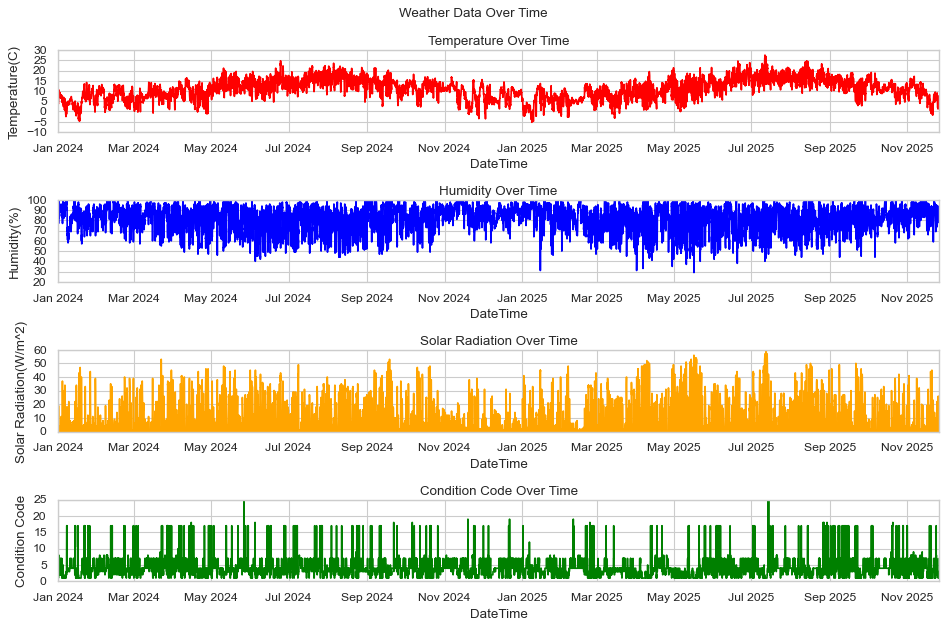

In [103]:
#
fig,ax = plt.subplots(4,1,figsize=(12,8))

fig.suptitle('Weather Data Over Time')

sns.lineplot(data=weather_df, x='DateTime', y='Temperature(C)', ax=ax[0], color='red')
ax[0].set_title('Temperature Over Time')
sns.lineplot(data=weather_df, x='DateTime', y='Humidity(%)', ax=ax[1], color='blue')
ax[1].set_title('Humidity Over Time')
sns.lineplot(data=weather_df, x='DateTime', y='Solar Radiation(W/m^2)', ax=ax[2], color='orange')
ax[2].set_title('Solar Radiation Over Time')
sns.lineplot(data=weather_df, x='DateTime', y='Condition Code', ax=ax[3], color='green')
ax[3].set_title('Condition Code Over Time')
plt.tight_layout()
plt.show()

## Predicting Solar Output from Weather

The object of this part of the project is to use numerical methods to predict the solar panel output based on weather infomation.

There are two sources of data , the solar system power generation rate , and the weather data which includes solar radiation , temperature and humidity. 

Various methods will be tried to compare there accuracy.

### Data Preperation

Both sources of data have already been loaded into data frames. 

__Solar Data : df_raw_daily_solar__

This has a grain of 5 minute intervals with measure for PV(W) - Solar Power

__ Weather : df_weather__

This has a grain of 10 minute intervals with measures for Temperature , Humidity and Solar Radiance.

The following will be done

1. Both data sets will be converted to the same grain ( 10 minute intervals) . 
2. The data sets will be merged into 1 data set
3. The data set will be normalized using the min max approach
4. The date time will be normalized using a data cyclic approach ( sine ) with the centre on the summer soltice

[Pandas : Resample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)

__Solar__

In [104]:
# Get the columns DateTime, PV(W) and only get times every 10 minutes
df_solar_10min = df_raw_daily_solar[['DateTime', 'PV(W)']].copy()
# filter to only keep rows where minute is multiple of 10 - because it is at 5 minute intervals
df_solar_10min = df_solar_10min[df_solar_10min['DateTime'].dt.minute % 10 == 0]
df_solar_10min.set_index('DateTime', inplace=True)
df_solar_10min.sort_index(inplace=True)

__Weather__

In [105]:
# Weather data also at 10 minute intervals so set index to DateTime
df_weather_10min = weather_df.copy()
# sort index
df_weather_10min.sort_index(inplace=True)
print("df_wather_10min shape:", df_weather_10min.shape)
print("df_solar_10min info:")
df_solar_10min.info()
print("df_weather_10min info:")
df_solar_10min.info()
# set index to DateTime
df_weather_10min.set_index('DateTime', inplace=True)
# Sort index
df_weather_10min.sort_index(inplace=True)


df_wather_10min shape: (100117, 5)
df_solar_10min info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58846 entries, 2024-09-12 00:00:00 to 2025-10-31 23:50:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PV(W)   58846 non-null  float64
dtypes: float64(1)
memory usage: 919.5 KB
df_weather_10min info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58846 entries, 2024-09-12 00:00:00 to 2025-10-31 23:50:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PV(W)   58846 non-null  float64
dtypes: float64(1)
memory usage: 919.5 KB


__Merge__

[merge_asof](https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html)

In [121]:
# Merge asof to get nearest time match
df_merged_10min = pd.merge_asof(left = df_solar_10min,
                                right = df_weather_10min, left_index=True, right_index=True, direction='nearest')
print("Merged 10-minute DataFrame shape:", df_merged_10min.shape)
# Now add datetime derived columns for analysis
# All centered around summer soltstice June 21 and noon , normalized between 0 and 1 using sin function
# Month of year, day of year, hour of day
df_merged_10min['Month_Sin'] = np.sin(2 * np.pi * (df_merged_10min.index.month - 1) / 12)
df_merged_10min['DayOfYear_Sin'] = np.sin(2 * np.pi * (df_merged_10min.index.dayofyear - 1) / 365)
df_merged_10min['HourOfDay_Sin'] = np.sin(2 * np.pi * (df_merged_10min.index.hour) / 24)
print("Final Merged DataFrame shape:", df_merged_10min.shape)
df_merged_10min.reset_index(inplace=True)
print("DataFrame info:")
df_merged_10min.info()
print("Columns:", df_merged_10min.columns.tolist())

Merged 10-minute DataFrame shape: (58846, 5)
Final Merged DataFrame shape: (58846, 8)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58846 entries, 0 to 58845
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DateTime                58846 non-null  datetime64[ns]
 1   PV(W)                   58846 non-null  float64       
 2   Temperature(C)          58846 non-null  Float64       
 3   Humidity(%)             58846 non-null  Float64       
 4   Solar Radiation(W/m^2)  58846 non-null  Float64       
 5   Condition Code          58846 non-null  Float64       
 6   Month_Sin               58846 non-null  float64       
 7   DayOfYear_Sin           58846 non-null  float64       
 8   HourOfDay_Sin           58846 non-null  float64       
dtypes: Float64(4), datetime64[ns](1), float64(4)
memory usage: 4.3 MB
Columns: ['DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(

__Histograms of each of the measures__

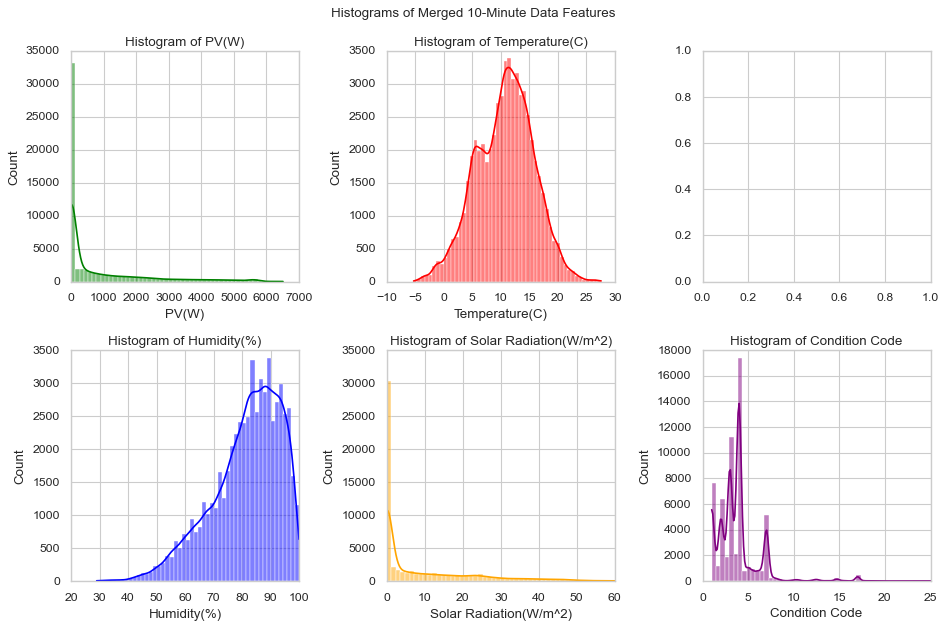

In [107]:
# histogram of of all the measures/features
fig, ax = plt.subplots(2,3, figsize=(12,8))
fig.suptitle('Histograms of Merged 10-Minute Data Features')
sns.histplot(data=df_merged_10min, x='PV(W)', bins=50, kde=True, ax=ax[0,0], color='green')
ax[0,0].set_title('Histogram of PV(W)')
sns.histplot(data=df_merged_10min, x='Temperature(C)', bins=50, kde=True, ax=ax[0,1], color='red')
ax[0,1].set_title('Histogram of Temperature(C)')
sns.histplot(data=df_merged_10min, x='Humidity(%)', bins=50, kde=True, ax=ax[1,0], color='blue')
ax[1,0].set_title('Histogram of Humidity(%)')
sns.histplot(data=df_merged_10min, x='Solar Radiation(W/m^2)', bins=50, kde=True, ax=ax[1,1], color='orange')
ax[1,1].set_title('Histogram of Solar Radiation(W/m^2)')
sns.histplot(data=df_merged_10min, x='Condition Code', bins=50, kde=True, ax=ax[1,2], color='purple')
ax[1,2].set_title('Histogram of Condition Code')
plt.tight_layout()
plt.show()

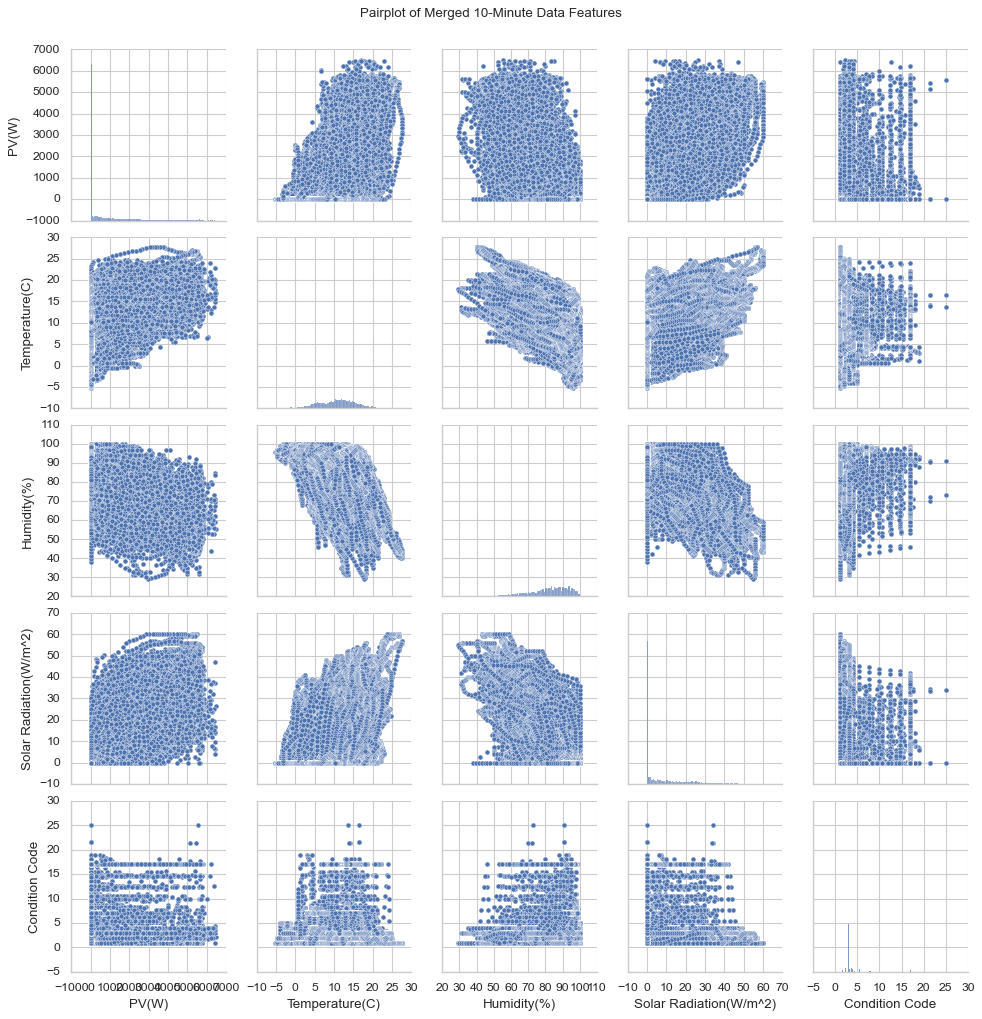

In [109]:
# Do a pairplot to see relationships between features
sns.pairplot(df_merged_10min[['PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)','Condition Code']])
plt.suptitle('Pairplot of Merged 10-Minute Data Features', y=1.02)
plt.show()

_Normalization_

The Min Max Scaler is used from scipy. This will convert each of the features or measures to a value between 0 -  1. This helps in traing. If the data is not scaled then there is a risk that one measure will override the others because of it's large relative magitude.

(MinMaxScaler)[https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html] 





In [122]:
# Normalize the data using Min-Max scaling
# check if scikit-learn is installed , only needed in Jupyter notebooks
#!pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_merged_10min_normalized = scaler.fit_transform(df_merged_10min[['PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']])
df_merged_10min_normalized = pd.DataFrame(df_merged_10min_normalized, columns=['PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin'])
print("Normalized 10-minute DataFrame shape:", df_merged_10min_normalized.shape)
print("DataFrame info:")
df_merged_10min_normalized.info()
print("Columns:", df_merged_10min_normalized.columns.tolist())



Normalized 10-minute DataFrame shape: (58846, 8)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58846 entries, 0 to 58845
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PV(W)                   58846 non-null  float64
 1   Temperature(C)          58846 non-null  float64
 2   Humidity(%)             58846 non-null  float64
 3   Solar Radiation(W/m^2)  58846 non-null  float64
 4   Condition Code          58846 non-null  float64
 5   Month_Sin               58846 non-null  float64
 6   DayOfYear_Sin           58846 non-null  float64
 7   HourOfDay_Sin           58846 non-null  float64
dtypes: float64(8)
memory usage: 3.6 MB
Columns: ['PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']


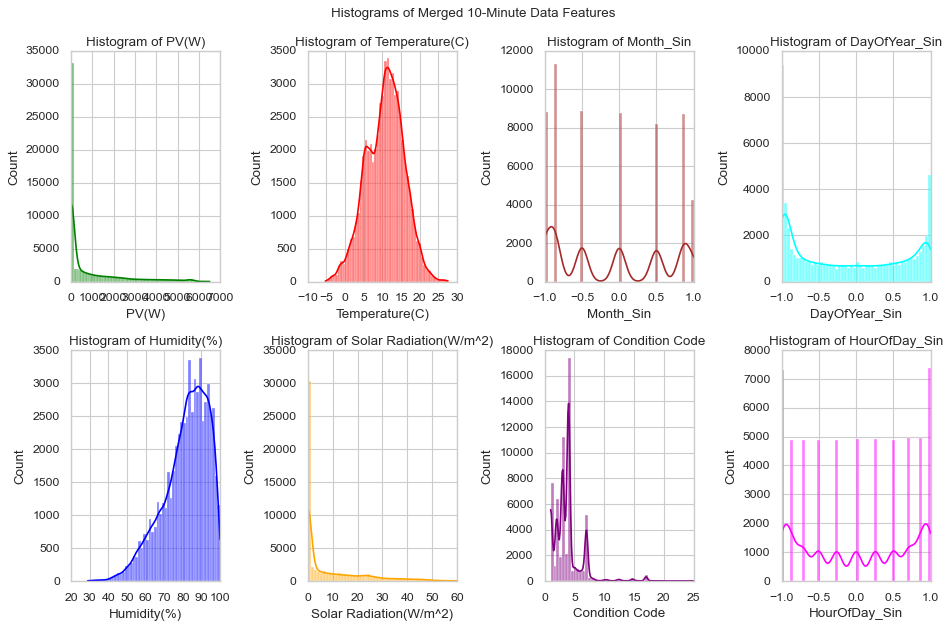

In [123]:
# histogram of of all the measures/features
fig, ax = plt.subplots(2,4, figsize=(12,8))
fig.suptitle('Histograms of Merged 10-Minute Data Features')
sns.histplot(data=df_merged_10min, x='PV(W)', bins=50, kde=True, ax=ax[0,0], color='green')
ax[0,0].set_title('Histogram of PV(W)')
sns.histplot(data=df_merged_10min, x='Temperature(C)', bins=50, kde=True, ax=ax[0,1], color='red')
ax[0,1].set_title('Histogram of Temperature(C)')
sns.histplot(data=df_merged_10min, x='Humidity(%)', bins=50, kde=True, ax=ax[1,0], color='blue')
ax[1,0].set_title('Histogram of Humidity(%)')
sns.histplot(data=df_merged_10min, x='Solar Radiation(W/m^2)', bins=50, kde=True, ax=ax[1,1], color='orange')
ax[1,1].set_title('Histogram of Solar Radiation(W/m^2)')
sns.histplot(data=df_merged_10min, x='Condition Code', bins=50, kde=True, ax=ax[1,2], color='purple')
ax[1,2].set_title('Histogram of Condition Code')
sns.histplot(data=df_merged_10min, x='Month_Sin', bins=50, kde=True, ax=ax[0,2], color='brown')
ax[0,2].set_title('Histogram of Month_Sin')
sns.histplot(data=df_merged_10min, x='DayOfYear_Sin', bins=50, kde=True, ax=ax[0,3], color='cyan')
ax[0,3].set_title('Histogram of DayOfYear_Sin')
sns.histplot(data=df_merged_10min, x='HourOfDay_Sin', bins=50, kde=True, ax=ax[1,3], color='magenta')
ax[1,3].set_title('Histogram of HourOfDay_Sin')
plt.tight_layout()
plt.show()

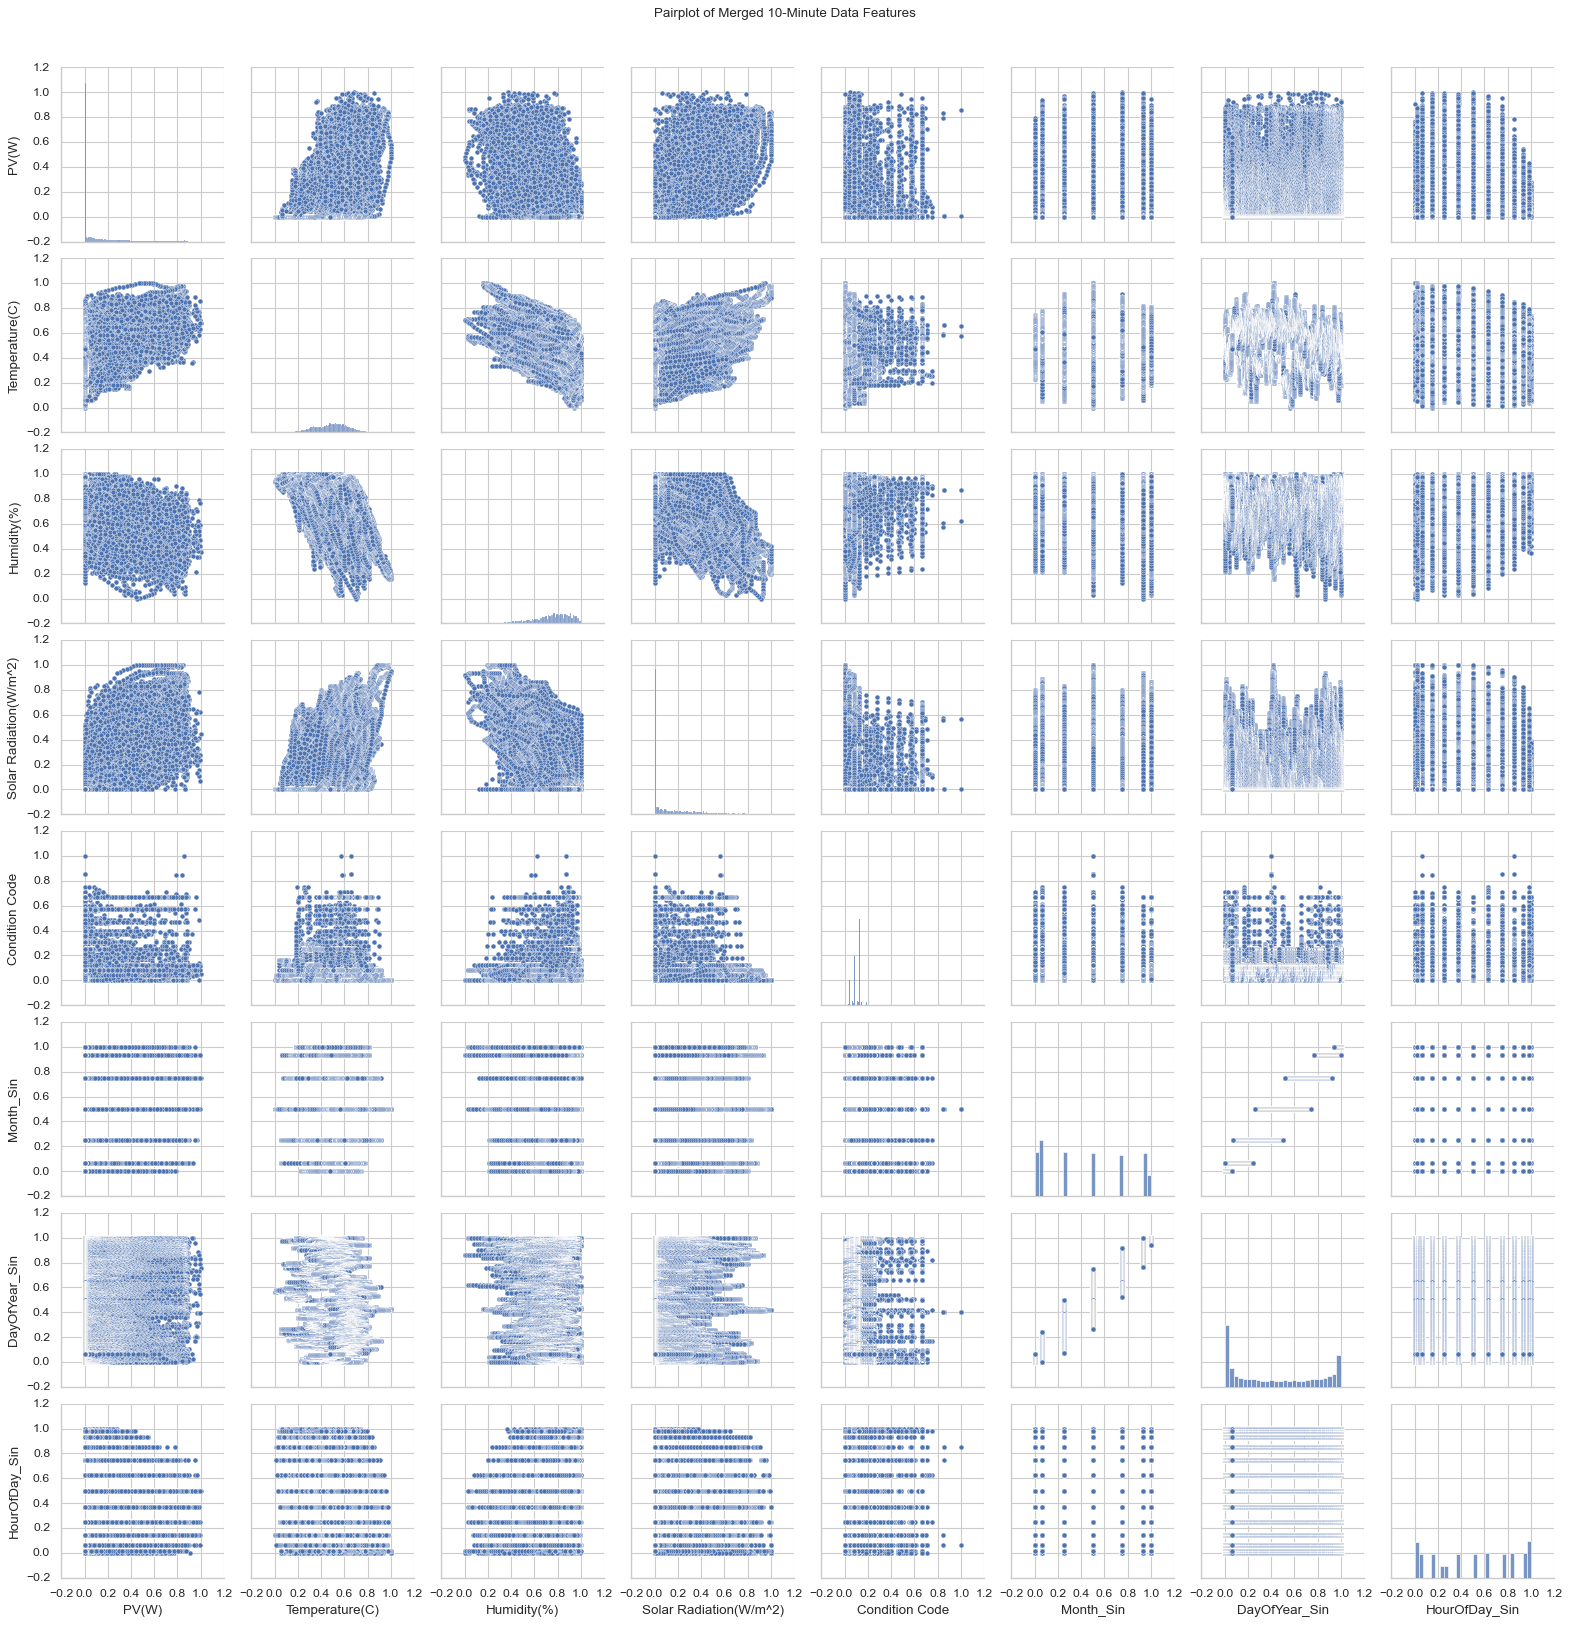

In [125]:
# Do a pairplot to see relationships between features
sns.pairplot(pd.DataFrame(df_merged_10min_normalized, columns=['PV(W)', 'Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code','Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']))
plt.suptitle('Pairplot of Merged 10-Minute Data Features', y=1.02)
plt.show()

Show normalized against , non - normalized values

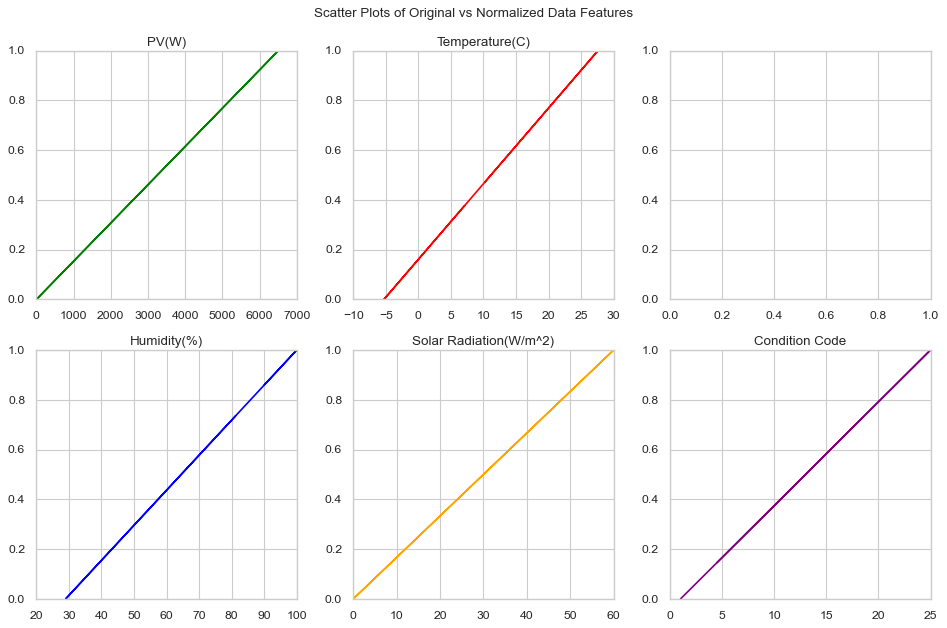

In [126]:
# Plot normalized data against original data to see the difference as a scatter plot
fig, ax = plt.subplots(2,3, figsize=(12,8))
fig.suptitle('Scatter Plots of Original vs Normalized Data Features')
ax[0,0].plot(df_merged_10min['PV(W)'], df_merged_10min_normalized['PV(W)'], color='green') 
ax[0,0].set_title('PV(W)')
ax[0,1].plot(df_merged_10min['Temperature(C)'], df_merged_10min_normalized['Temperature(C)'], color='red')
ax[0,1].set_title('Temperature(C)')
ax[1,0].plot(df_merged_10min['Humidity(%)'], df_merged_10min_normalized['Humidity(%)'], color='blue')
ax[1,0].set_title('Humidity(%)')
ax[1,1].plot(df_merged_10min['Solar Radiation(W/m^2)'], df_merged_10min_normalized['Solar Radiation(W/m^2)'], color='orange')
ax[1,1].set_title('Solar Radiation(W/m^2)')
ax[1,2].plot(df_merged_10min['Condition Code'], df_merged_10min_normalized['Condition Code'], color='purple')
ax[1,2].set_title('Condition Code')
plt.tight_layout()
plt.show()

### Apply random forrest

Mean Squared Error: 0.009737184579113442
R^2 Score: 0.823796837969226
Number of samples used for MAPE calculation: 5343
Total samples in y_test: 6966
MAPE (threshold=0.01): 42.15%
Mean Absolute Percentage Error (MAPE): 42.14826469201169 %
Feature: Temperature(C), Importance: 0.13398690007321856
Feature: Humidity(%), Importance: 0.13583608955314658
Feature: Solar Radiation(W/m^2), Importance: 0.4921928870396692
Feature: Condition Code, Importance: 0.04442277727160775
Feature: Month_Sin, Importance: 0.014781403195309718
Feature: DayOfYear_Sin, Importance: 0.08759653009794723
Feature: HourOfDay_Sin, Importance: 0.09118341276910101


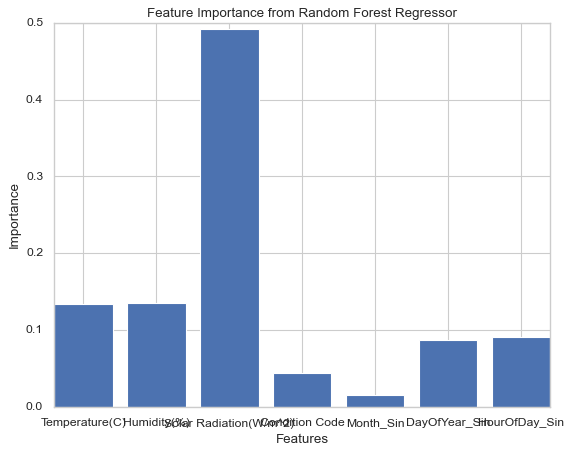

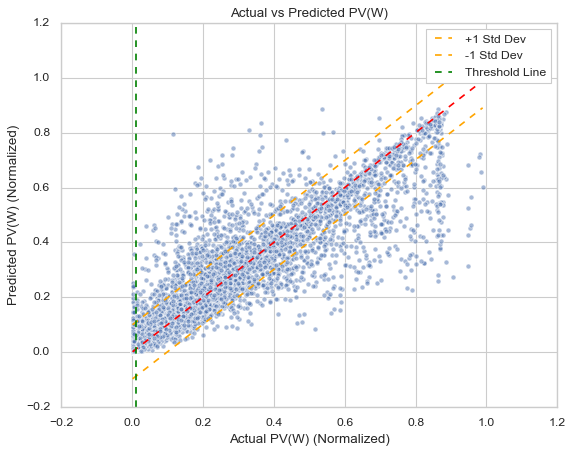

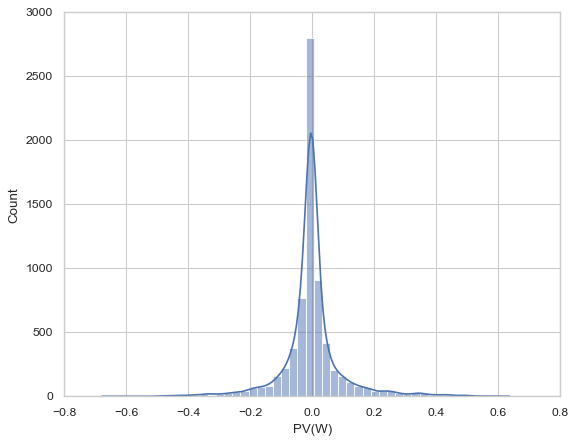

In [127]:
# do random forest regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Define features and target variable
# exclude PV(W) which is close to zero most of the time
threshold = 0.001
mask = df_merged_10min_normalized['PV(W)'] > threshold
X = df_merged_10min_normalized.loc[mask, ['Temperature(C)', 'Humidity(%)', 'Solar Radiation(W/m^2)', 'Condition Code', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']]
y = df_merged_10min_normalized.loc[mask, 'PV(W)']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the model
rf_model.fit(X_train, y_train)
# Make predictions
y_pred = rf_model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Calculate MAPE , ignore division by zero warnings
import numpy as np  
# Exclude values below a threshold (e.g., 0.01)
threshold = 0.01
mask = np.abs(y_test) > threshold
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred[mask]
print(f"Number of samples used for MAPE calculation: {len(y_test_filtered)}")
print(f"Total samples in y_test: {len(y_test)}")
mape = np.mean(np.abs((y_test_filtered - y_pred_filtered) / y_test_filtered)) * 100
print(f"MAPE (threshold={threshold}): {mape:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")
# ...existing code...
# Feature importance
importances = rf_model.feature_importances_
feature_names = X.columns
for feature, importance in zip(feature_names, importances):
    print(f"Feature: {feature}, Importance: {importance}")  
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest Regressor')
# plot the test zeros vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual PV(W) (Normalized)')
plt.ylabel('Predicted PV(W) (Normalized)')
plt.title('Actual vs Predicted PV(W)')
# plot a diagonal line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
# plot standard deviation lines diagonally
std_dev = np.std(y_test - y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test) + std_dev, max(y_test) + std_dev], color='orange', linestyle='--', label='+1 Std Dev')
plt.plot([min(y_test), max(y_test)], [min(y_test) - std_dev, max(y_test) - std_dev], color='orange', linestyle='--', label='-1 Std Dev')
# plot a line for the test threshold horizontal
plt.axvline(x=threshold, color='green', linestyle='--', label='Threshold Line')
plt.legend()
# Plot error distribution
errors = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=50, kde=True)
plt.show()
# how good is the prediction

Now convert back to real values

MAPE on original scale (threshold=65.07000000000001): 42.15%


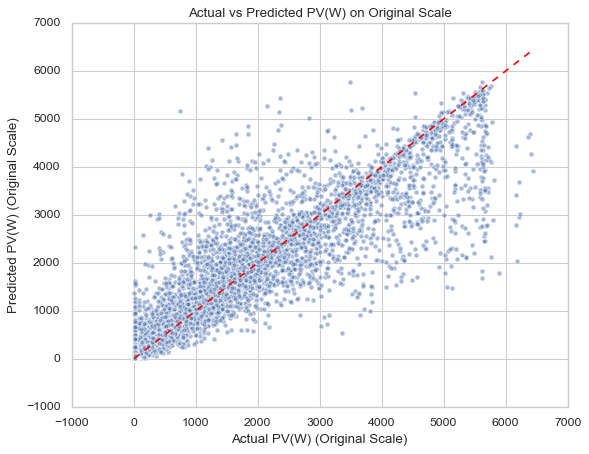

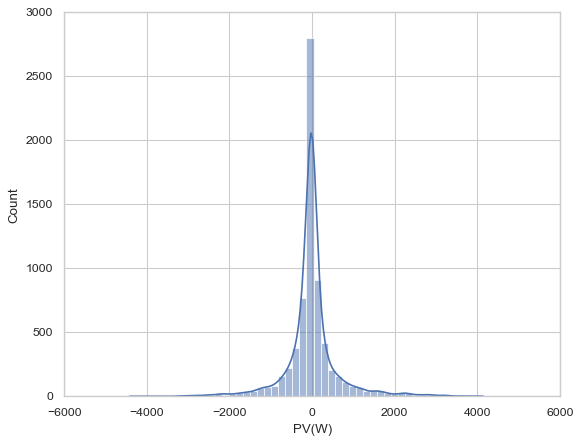

In [128]:
# convert the normalized predictions back to original scale
y_test_original = y_test * (df_merged_10min['PV(W)'].max() - df_merged_10min['PV(W)'].min()) + df_merged_10min['PV(W)'].min()
y_pred_original = y_pred * (df_merged_10min['PV(W)'].max() - df_merged_10min['PV(W)'].min()) + df_merged_10min['PV(W)'].min()
# calculate MAPE on original scale
threshold_original = 0.01 * (df_merged_10min['PV(W)'].max() - df_merged_10min['PV(W)'].min()) + df_merged_10min['PV(W)'].min()
mask_original = np.abs(y_test_original) > threshold_original
y_test_original_filtered = y_test_original[mask_original]
y_pred_original_filtered = y_pred_original[mask_original]
mape_original = np.mean(np.abs((y_test_original_filtered - y_pred_original_filtered) / y_test_original_filtered)) * 100

print(f"MAPE on original scale (threshold={threshold_original}): {mape_original:.2f}%")
# scatter plot of actual vs predicted on original scale
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.xlabel('Actual PV(W) (Original Scale)')
plt.ylabel('Predicted PV(W) (Original Scale)')
plt.title('Actual vs Predicted PV(W) on Original Scale')
# plot a diagonal line
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
# Plot error distribution on original scale
errors_original = y_test_original - y_pred_original
plt.figure(figsize=(8, 6))
sns.histplot(errors_original, bins=50, kde=True)
plt.show()

### Now try xboost

## Cleanup

In [ ]:
# Close the database connection
sys_cur.close()
con.close()